In [1]:
### Display configurations
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
from datetime import datetime, timedelta
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
%matplotlib inline

KEY_STATE, KEY_COUNTRY = "Province_State", "Country_Region"
BASE_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv"

def picklecreator(dates, dflist):
    for i, my_df in enumerate(dflist):
        date = dates[i].strftime("%Y-%m-%d")
        my_file = Path(f"../data/gis_data_{date}.pkl")
        if not (my_file.is_file()):
            my_df.to_pickle(f'./data/gis_data_{date}.pkl')
    return 1

def pickleloader(date):
    my_file = Path(f"../data/gis_data_{date}.pkl")
    if my_file.is_file():
        return df.load(my_file)
    return 

def get_df(date):
    base = date - timedelta(days=1)
    d = base.strftime("%m-%d-%Y")
    url = BASE_URL.format(d)
    s = requests.get(url).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))
    country_key = KEY_COUNTRY if (KEY_COUNTRY in df.columns) else KEY_COUNTRY.replace("_", "/")
    country_replace = lambda x: "United States" if x == "US" else x
    # TODO: Fix "Korea, South"
    df[country_key] = df[country_key].map(country_replace)
    return (base, df)

def get_counts(df, STATE1, STATE2, attribute):
    if KEY_STATE in df.columns:
        key_state, key_us = KEY_STATE, KEY_COUNTRY
    else:
        key_state, key_us = KEY_STATE.replace("_", "/"), KEY_COUNTRY.replace("_", "/")
    state1_mask, state2_mask, us_mask = df[key_state] == STATE1, df[key_state] == STATE2, df[key_us] == "United States"
    return [df[state1_mask][attribute].sum(), df[state2_mask][attribute].sum(), df[us_mask][attribute].sum()]

def get_perc(c):
    # ca1, ny1, us1, ca2, ny2, us2 = c
    percentages = [(c[3] - c[0]) / c[0], (c[4] - c[1]) / c[1], (c[5] - c[2]) / c[2]]
    return [round(100 * x, 2) for x in percentages]

def get_df_list(month, day):
    past = (datetime(2020, month, day) - datetime(2020, 3, 16)).days
    date_list = [datetime(2020, month, day) - timedelta(days=x) for x in range(past)]
    return [get_df(date) for date in date_list]

def get_data(df_list, STATE1, STATE2, attribute="Confirmed"):
    date_counts, date_percs = [], []
    for date, df in df_list:
        c = get_counts(df, STATE1, STATE2, attribute)
        date_counts.append((date, [c[0], c[1], c[2]]))
    for i in range(len(date_counts) - 1, 0, -1):
        perc = get_perc(date_counts[i][1] + date_counts[i - 1][1])
        date_percs.append((date_counts[i-1][0], perc))
    state1 = [p[1][0] for p in date_percs], [c[1][0] for c in date_counts[1:]]
    state2 = [p[1][1] for p in date_percs], [c[1][1] for c in date_counts[1:]]
    us = [p[1][2] for p in date_percs], [c[1][2] for c in date_counts[1:]]
    return state1, state2, us

def plot_one_line(time_data, y, ylabel):
    fig, ax = plt.subplots(1, figsize=(10,4))
    delta = timedelta(days=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))        
    ax.set_xlim([min(time_data) - delta, max(time_data) + delta])
    ax.plot_date(time_data, y, 'b-');
    ax.set_ylabel(ylabel)
    return

def perc_count_pairs(time_data, y_data, attribute):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(13,8))
    zipped = [[(ax1, p), (ax2, c)] for (p, c) in y_data]
    for (ax1, y1), (ax2, y2) in zipped:
        delta = timedelta(days=1)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))        
        ax1.set_xlim([min(time_data) - delta, max(time_data) + delta])
        ax1.plot_date(time_data, y1);
        ax1.set_ylabel(f"day-over-day increase of {attribute}")
        ax2.set_ylabel(f"Number of {attribute}")
        ax2.plot_date(time_data, y2);
        legend = (f"{STATE1}", f"{STATE2}", "United States")
        ax1.legend(legend)
        ax2.legend(legend)

def get_all_states(df):
    all_states = list(set(df[df["Country_Region"] == "United States"]["Province_State"]))
    all_states.remove("Diamond Princess")
    all_states.remove("Grand Princess")
    all_states.remove("Guam")
    all_states.remove("Northern Mariana Islands")
    all_states.remove("Recovered")
    all_states.remove("Virgin Islands")
    all_states.remove("Puerto Rico")
    all_states.remove("District of Columbia")
    df_pop = pd.read_csv("data/nst-est2019-alldata.csv")
    df_pop = df_pop[df_pop.NAME.isin(all_states)]
    state_pop = dict(df_pop[["NAME", "POPESTIMATE2018"]].values)
    return all_states, state_pop

def group_per_df(gis_data, attribute="Confirmed"):
    grouped_state_df_list = []
    for date, df in gis_data:
        key = KEY_STATE if KEY_STATE in df.columns else KEY_STATE.replace("_", "/")
        state_df = df[df[key].isin(all_states)]
        grouped_state_df = state_df[[key, attribute]].groupby(key).sum().reset_index()
        grouped_state_df["population"] = [state_pop[x] for x in grouped_state_df[key]]
        grouped_state_df["capita_per_mil"] = round(1000000 * grouped_state_df[attribute] / grouped_state_df["population"], 3)
        grouped_state_df["1_in_x"] = round(grouped_state_df["population"] / grouped_state_df[attribute])
        grouped_state_df.sort_values(by="capita_per_mil", ascending=False, inplace=True)
        grouped_state_df_list.append((date, grouped_state_df))
    return grouped_state_df_list

def get_state_csv(grouped_state_df_list, all_states, metric="capita_per_mil"):
    N = len(grouped_state_df_list)
    all_dates = [grouped_state_df_list[i][0].strftime("%B %d") for i in range(N)]
    count_dict = [{"state": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    state_dict = {s: {"state": s} for s in all_states}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in state_dict.values()]

    for i in range(N):
        date_string = grouped_state_df_list[i][0].strftime("%B %d")
        key = KEY_STATE if (KEY_STATE in grouped_state_df_list[i][1].columns) else KEY_STATE.replace("_", "/")
        df_temp = grouped_state_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for state, count in data_list:
            state_dict[state][date_string] = count
    return state_dict

def save_flag_csv(my_dict, all_states, metric="state_rate"):
    my_df = pd.DataFrame(my_dict.values())
    old_columns = list(my_df.columns)
    base_flag_url = 'https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/images/flags/{state_name}-large.png'
    my_df['url'] = [base_flag_url.format(state_name=state.replace(" ", "-").lower()) for state in all_states]
    my_df = my_df[[old_columns[0], 'url'] + old_columns[1:]]
    my_df.to_csv(r'{metric}_data.csv'.format(metric=metric), index=False)
    print(f"saved to {metric}_data.csv at " + datetime.strftime(datetime.now(), format="%I:%M:%S %p"))
    
%matplotlib inline

def get_deltas(y):
    return [max(y[i+1] - y[i], 0) for i in range(len(y) - 1)]

def get_rolling_avg(y, N):
    return [sum([y[i - k] for k in range(N)]) / N for i in range(N-1, len(y))]

def plot_four_bar(time_data, y, ylabel):
    fig, ax = plt.subplots(1, figsize=(12,7))
    delta = timedelta(days=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.set_xlim([min(time_data) - delta, max(time_data) + delta])
    ax.xaxis_date()
    ax.bar(time_data, y, width=1.0, edgecolor='w');
    ax.set_ylabel(ylabel)
    return

def plot_one_bar(time_data, y, roll_avg, N, ylabel):
    fig, ax = plt.subplots(1, figsize=(16,7))
    delta = timedelta(days=1)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.set_xlim([min(time_data) - delta, max(time_data) + delta])
    ax.xaxis_date()
    ax.plot(time_data, roll_avg, c='r', label=r"{N}d avg".format(N=N))
    ax.set_ylabel(ylabel)
    ax.legend(shadow=True, fancybox=True)    
    ax.bar(time_data, y, width=1.0, edgecolor='w', color='cornflowerblue');
    ax.set_ylabel(ylabel)
    return

def get_data_level(level):
    if level == "county": return "Admin2"
    elif level == "state": return "Province_State"
    else: return "Country_Region"

def get_covid_attribute(y_t, level="county", region="San Francisco", attribute="Confirmed", N=7):
    n, y = len(y_t), []
    for i in range(n):
        df = gis_data[n - 1 - i][1]
        data_level = get_data_level(level)
        if data_level not in df.columns:
            data_level = data_level.replace("_", "/")
        attribute = attribute.strip().title()
        y.append(sum(df[df[data_level] == region][attribute].values))
    delta_y = get_deltas(y)
    return delta_y[N-1:], get_rolling_avg(delta_y, N)

def get_region_data(region_list, level="state", attribute="Confirmed"):
    num_regions, y_t, N = len(region_list), time_data[:-5][::-1], 7
    bar_list, roll_avg_list = [[] for __ in range(num_regions)], [[] for __ in range(num_regions)]
    for i in range(num_regions):
        bar_list[i], roll_avg_list[i] = get_covid_attribute(y_t, level, region_list[i], attribute, N)
    return y_t[N:], bar_list, roll_avg_list
        
def plot_region_data(y_t, bar_list, roll_avg_list, region_list, attribute="Confirmed"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8), sharex='all')
    if attribute == "Confirmed":
        ylabel = " New Cases" 
    else:
        ylabel = " Deaths"
    for i, ax in enumerate([ax1, ax2, ax3, ax4]):
        ax.bar(y_t, bar_list[i], width=1.0, color='cornflowerblue', edgecolor='w')
        ax.plot(y_t, roll_avg_list[i], c='r', label=r"{N}d avg".format(N=N))
        ax.set_ylabel(region_list[i] + ylabel)
        ax.legend(shadow=True, fancybox=True)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    fig.suptitle(f"COVID-19 {attribute}", y=1.01)
    fig.tight_layout()
    
def plot_daily(time_data, y, label, attribute="Confirmed"):
    n = len(y)
    increases = []
    for i in range(n - 1):
        diff = y[i+1] - y[i]
        increases.append(diff / y[i] * 100)
    print(f"Avg daily increase {attribute}", round(sum(increases) / len(increases), 4))
    plot_one_line(time_data[::-1][1:], increases, f"{label} Daily % Increase {attribute}")    
    
def get_country_or_state_count(time_data, level="country", state="", attribute="Confirmed"):
    count = []
    for i in range(len(time_data)):
        if level == "country":
            key = KEY_COUNTRY if KEY_COUNTRY in gis_data[i][1].columns else KEY_COUNTRY.replace("_", "/")
            level_mask = gis_data[i][1][key] == "United States"
        elif level == "state":
            key = KEY_STATE if KEY_STATE in gis_data[i][1].columns else KEY_STATE.replace("_", "/")
            level_mask = gis_data[i][1][key] == state
        date_sum = sum(gis_data[i][1].loc[level_mask, attribute].values)
        count.append(date_sum)
    return count[::-1]



In [4]:
# A very expensive call
# TODO: Pickle, save, and load
gis_data = get_df_list(9, 25)

In [5]:
time_data = [date for date, _ in gis_data[0:-1:]]
print(time_data[0])
gis_data[0][1].head()

2020-09-24 00:00:00


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-09-25 04:23:21,33.93911,67.709953,39170,1451,32619,5100.0,Afghanistan,100.620779,3.704366
1,NaN,NaN,NaN,Albania,2020-09-25 04:23:21,41.15330,20.168300,12921,370,7239,5312.0,Albania,448.988811,2.863555
2,NaN,NaN,NaN,Algeria,2020-09-25 04:23:21,28.03390,1.659600,50579,1703,35544,13332.0,Algeria,115.342753,3.367010
3,NaN,NaN,NaN,Andorra,2020-09-25 04:23:21,42.50630,1.521800,1753,53,1203,497.0,Andorra,2268.815117,3.023388
4,NaN,NaN,NaN,Angola,2020-09-25 04:23:21,-11.20270,17.873900,4475,162,1503,2810.0,Angola,13.615784,3.620112


In [6]:
dates = [gis_data[k][0] for k in range(len(gis_data))]
dflist = [gis_data[k][1] for k in range(len(gis_data))]
picklecreator(dates, dflist)

1

In [8]:
# [gis_data.insert(0, get_df(datetime(2020, 8, k))) for k in range(13, 17)] # gis_data.insert(0, get_df(datetime(2020, 8, 1)))
# time_data = [date for date, _ in gis_data[0:-1:]]
[print(time_data[k]) for k in range(9)];

2020-09-24 00:00:00
2020-09-23 00:00:00
2020-09-22 00:00:00
2020-09-21 00:00:00
2020-09-20 00:00:00
2020-09-19 00:00:00
2020-09-18 00:00:00
2020-09-17 00:00:00
2020-09-16 00:00:00


In [9]:
# Bay Area numbers
# i = 0
# key_state = KEY_STATE if KEY_STATE in gis_data[i][1].columns else KEY_STATE.replace("_", "/")
# state_mask = gis_data[i][1][key_state] == "California"
# counties = gis_data[i][1][state_mask]["Admin2"].unique()
# bay_area = ['Alameda', 'Contra Costa', 'Marin', 'Mendocino', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Santa Cruz', 'Sonoma', 'Solano']
# county_mask = gis_data[0][1]["Admin2"].isin(bay_area)
# gis_data[0][1][county_mask & state_mask]

7d rolling average on September 24: 737
total deaths: 200772


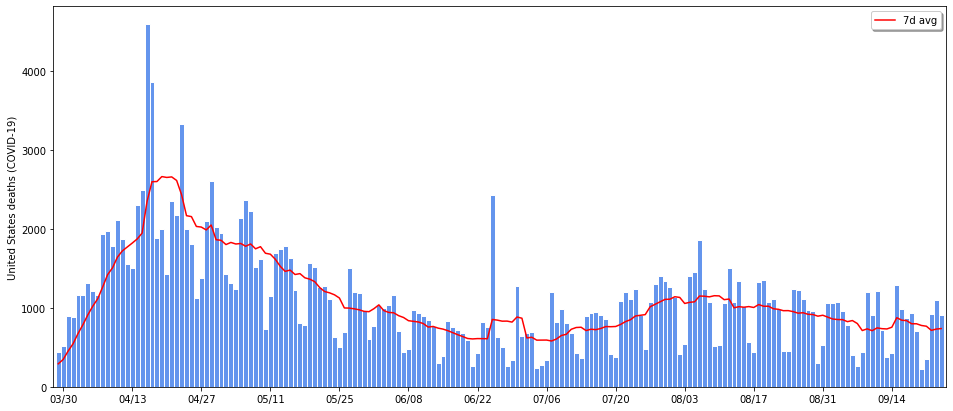

In [10]:
y_t = time_data[:-5][::-1]
level, attribute, region, N = "country", " deaths", "United States", 7
# level, region, attribute, N = "state", "Florida", " Deaths", 7
data, roll_avg = get_covid_attribute(y_t, level, region, attribute, N)
print(f"7d rolling average on {y_t[-1].strftime('%B %d')}: {int(roll_avg[-1])}")
print("total deaths:", sum(data))
plot_one_bar(y_t[N:], data, roll_avg, N, region + attribute + " (COVID-19)");

September 24: San Francisco 53 San Mateo 54 Santa Clara 123 Alameda 112


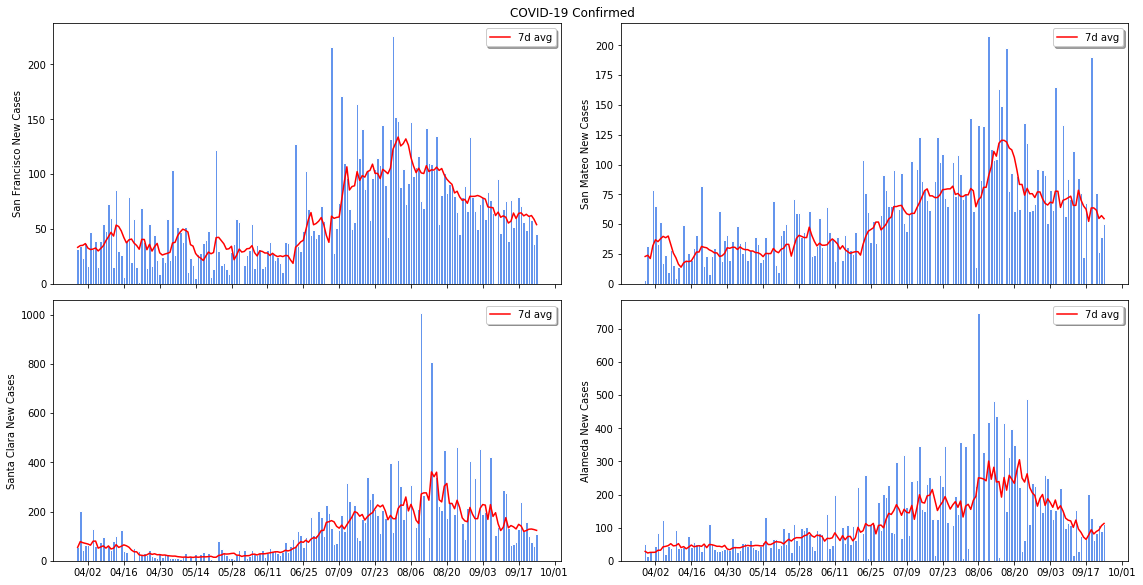

In [12]:
level, attribute, region_list = "county", "Confirmed", ["San Francisco", "San Mateo", "Santa Clara", "Alameda"]
# level, attribute, region_list = "state", "Confirmed", ["California", "Texas", "Florida", "Georgia"]
y_t, bar_list, roll_avg_list = get_region_data(region_list, level, attribute)
plot_region_data(y_t, bar_list, roll_avg_list, region_list, attribute)
print(y_t[-1].strftime("%B %d") + ": " + " ".join([reg + " " + str(int(ra[-1])) for reg, ra in zip(region_list, roll_avg_list)]))

In [38]:
state_count = get_country_or_state_count(time_data, "state", "California")
# country_count = get_country_or_state_count(time_data, "country")
# plot_one_line(time_data[::-1], country_count, ylabel="United States Cumulative Cases")
# plot_one_line(time_data[::-1], state_count, ylabel=f"{state} Cumulative cases")

Avg daily increase Deaths 0.5406


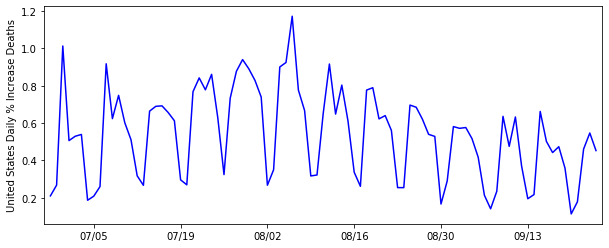

In [13]:
lookback = -(len(time_data) - 90)
region, attribute, t = "United States", "Deaths", time_data[:lookback]
plot_daily(t, get_country_or_state_count(t, "country", region, attribute), region, attribute)

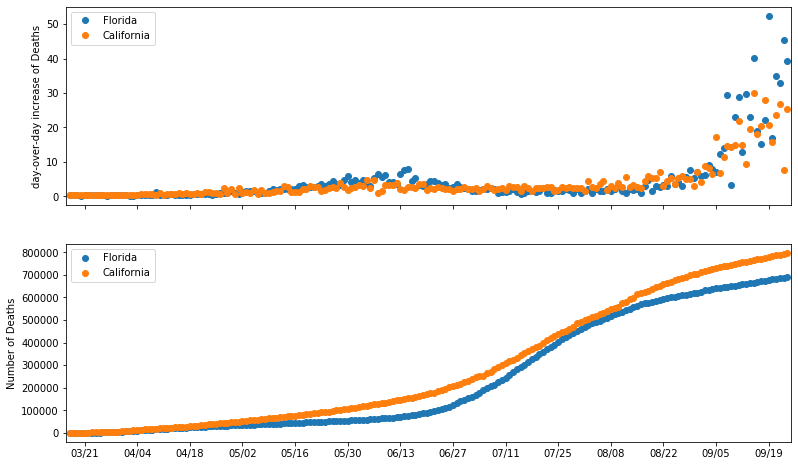

In [14]:
STATE1, STATE2 = "Florida", "California"
perc_count_pairs(time_data, get_data(gis_data, STATE1, STATE2)[:-1], attribute="Deaths")

# Get state per capita data

In [15]:
all_states, state_pop = get_all_states(gis_data[0][1])
grouped_state_df_list = group_per_df(gis_data)
rate_dict = get_state_csv(grouped_state_df_list, all_states, "capita_per_mil")
save_flag_csv(rate_dict, all_states, "state_rate")
count_dict = get_state_csv(grouped_state_df_list, all_states, "Confirmed")
save_flag_csv(count_dict, all_states, "state_cases")

saved to state_rate_data.csv at 03:52:51 PM
saved to state_cases_data.csv at 03:52:51 PM


In [16]:
# save_flag_csv
grouped_state_df_list = group_per_df(gis_data, "Deaths")
rate_dict = get_state_csv(grouped_state_df_list, all_states, "capita_per_mil")
save_flag_csv(rate_dict, all_states, "state_death_rate")
count_dict = get_state_csv(grouped_state_df_list, all_states, "Deaths")
save_flag_csv(count_dict, all_states, "state_death_counts")

saved to state_death_rate_data.csv at 03:52:52 PM
saved to state_death_counts_data.csv at 03:52:53 PM


In [17]:
x = grouped_state_df_list[0][1][["Province_State", "capita_per_mil"]]
x.reset_index(inplace=True, drop=True)
print(time_data[0])
x

2020-09-24 00:00:00


,Province_State,capita_per_mil
0,New Jersey,1810.821
1,New York,1694.542
2,Massachusetts,1360.235
3,Connecticut,1259.688
4,Louisiana,1163.811
5,Rhode Island,1045.085
6,Mississippi,964.100
7,Arizona,776.611
8,Michigan,703.020
9,Illinois,689.613


In [335]:
# STATE1, STATE2 = "Arkansas", "Mississippi"
# y = get_data(gis_data, STATE1, STATE2)[:-1] # y[0] = counts, y[1] = daily_increase
# rates = list(rate_dict[STATE1].values())[1:], list(rate_dict[STATE2].values())[1:]
# rates
# perc_count_pairs(time_data, y)
# top5, q = list(x["Province_State"].values[:5]), list(rate_dict.items())
# [list(q[i][1].items()) for i in range(50) if q[i][0] in top20]

# Country cases per capita

In [18]:
gis_data[0][1]['Country_Region']

def get_all_countries(df):
    all_countries = set(gis_data[0][1]['Country_Region'])
    df_pop = pd.read_csv("data/prb-2019.csv")
    df_pop = df_pop.loc[df_pop["Type"] == "Country"][["FIPS", "Name", "Data"]]
    # make country code dict to get two letter codes; e.g. US, CA, etc.
    # https://github.com/google/region-flags/tree/gh-pages/png
    url = "https://raw.githubusercontent.com/google/region-flags/gh-pages/png/{code}.png"
    df_pop["url"] = [url.format(code=c) for c in df_pop["FIPS"].values]
    df_pop.drop(["FIPS"], axis=1, inplace=True)
    df_pop = df_pop[["Name", "url", "Data"]]
    df_pop.columns = ["country", "url", "data"]
    df_pop.sort_values(by="data", inplace=True)
    df_pop = df_pop[df_pop["data"] >= 5]
    world_countries = set(df_pop["country"].unique())
    both = world_countries.intersection(all_countries)
    df_pop = df_pop[df_pop["country"].isin(both)]
    world_pop = dict(df_pop[["country", "data"]].values)
    country_url = dict(df_pop[df_pop["country"].isin(both)][["country", "url"]].values)
    return both, world_pop, country_url

def group_per_df_country(gis_data, attribute="Confirmed"):
    all_countries, world_pop, country_url = get_all_countries(gis_data[0][1])
    grouped_country_df_list = []
    for date, df in gis_data:
        key = KEY_COUNTRY if KEY_COUNTRY in df.columns else KEY_COUNTRY.replace("_", "/")
        country_df = df[df[key].isin(all_countries)]
        grouped_country_df = country_df[[key, attribute]].groupby(key).sum().reset_index()
        grouped_country_df["population"] = [int(world_pop[x] * 1000000) for x in grouped_country_df[key]]
        grouped_country_df["capita"] = round(1000000 * grouped_country_df[attribute] / grouped_country_df["population"], 3)
        grouped_country_df.sort_values(by="capita", ascending=False, inplace=True)
        grouped_country_df["url"] = [country_url[country] for country in grouped_country_df[key]]
        grouped_country_df_list.append((date, grouped_country_df))
    return grouped_country_df_list, all_countries, country_url

def get_csv(grouped_country_df_list, all_countries, country_url, metric="capita"):
    N = len(grouped_country_df_list)
    all_dates = [grouped_country_df_list[i][0].strftime("%B %d") for i in range(N)]
    count_dict = [{"country": None, "url": None} for i in range(N)]
    [count_dict[i].update({date: None for date in all_dates}) for i in range(N)]
    country_dict = {c: {"country": c, "url": u} for c, u in country_url.items()}
    [d.update({date: 0 for date in all_dates[::-1]}) for d in country_dict.values()]

    for i in range(N):
        date_string = grouped_country_df_list[i][0].strftime("%B %d")
        key = KEY_COUNTRY if (KEY_COUNTRY in grouped_country_df_list[i][1].columns) else KEY_COUNTRY.replace("_", "/")
        df_temp = grouped_country_df_list[i][1][[key, metric]]
        data_list = df_temp.values.tolist()
        for country, count in data_list:
            country_dict[country][date_string] = count
    return country_dict

def save_csv(my_dict, metric="capita"):
    my_df = pd.DataFrame(my_dict.values())
    my_df.to_csv(r'{metric}_country_data.csv'.format(metric=metric), index=False)
    print(f"saved to {metric}_country_data.csv at " + datetime.strftime(datetime.now(), format="%I:%M:%S %p"))

grouped_country_df_list, all_countries, country_url = group_per_df_country(gis_data)
metric = "capita"
country_dict = get_csv(grouped_country_df_list, all_countries, country_url, metric)
country_dict.pop('China')
save_csv(country_dict, metric)
metric = "Confirmed"
count_country_dict = get_csv(grouped_country_df_list, all_countries, country_url, 'Confirmed')
count_country_dict.pop('China')
save_csv(count_country_dict, "Confirmed")

saved to capita_country_data.csv at 03:53:09 PM
saved to Confirmed_country_data.csv at 03:53:09 PM
